In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
# Import forecast data data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds, engine='netcdf4')

In [3]:
ivt = {key : bb.Met.calc_ivt(value.q, value.u, value.v).mean('number') for key, value in exp.items()}

In [4]:
# Plot settings

region = 'eu'
if region=='uk':
    # UK
    lat_max = 62
    lat_min = 47
    lon_min = -12
    lon_max = 5
if region=='eu':
    #Europe
    lat_max = 70
    lat_min = 33
    lon_min = -27
    lon_max = 25

tp_min = 250 # IVT in kg/m^2/s
tp_max = 1200

p_min = 90800 # Pressure in hPa
p_max= 91000

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/e/ermis/nobackups/minicond

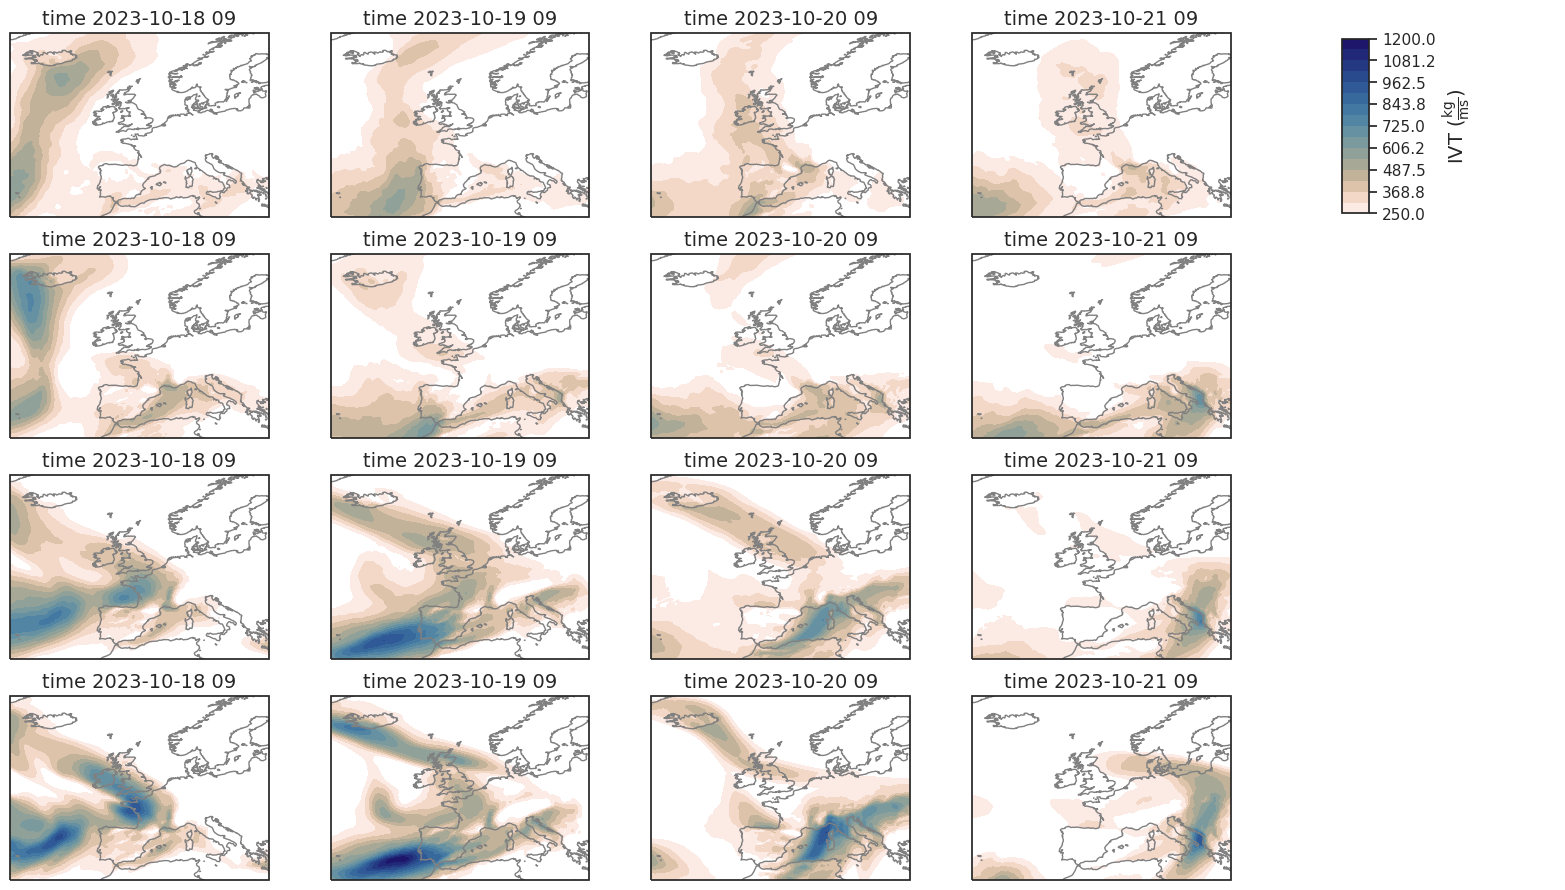

In [5]:
# Calculate integrated water vapour transport (IVT)

# figure and map setup
fs=14
projection = ccrs.PlateCarree()
longitude =exp['curr'].longitude.values
latitude = exp['curr'].latitude.values
fig = plt.figure(1, figsize=(20, 11))

# Map -----------------
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
for ini, inidate in enumerate(inidates):
    for t, time in enumerate(['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']):
        ax = plt.subplot(4,5,t+1+ini*5, projection = projection)
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

        # data for plotting
        tp_vals = ivt['curr'].sel(inidate=inidate, time=time).squeeze().values*100
        p_vals = exp['curr'].z.sel(inidate=inidate, time=time, level=850).mean('number').squeeze().values

        # tp as shading
        clevs_tp = np.linspace(tp_min, tp_max, 17)
        cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                        transform=projection)
        plt.title('time '+time[:13], fontsize=fs)

        # geopotential as contours
        clevs_p = np.linspace(p_min, p_max, 17)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection)
        plt.clabel(cs, fmt='%d')

# Other figure settings -----------------
ax = plt.subplot(4,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label=r'IVT ($\frac{\mathrm{kg}}{\mathrm{m}\mathrm{s}}$)', extend = 'max', shrink=0.8)
cbar.set_label(label=r'IVT ($\frac{\mathrm{kg}}{\mathrm{m}\mathrm{s}}$)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

plt.savefig('figures/05_ivt_curr_{}.png'.format(region))
plt.savefig('figures/05_ivt_curr_{}.pdf'.format(region))

# Time series for ERA5

In [6]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/pl/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

In [7]:
ivt_era = bb.Met.calc_ivt(era5.q, era5.u, era5.v)

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


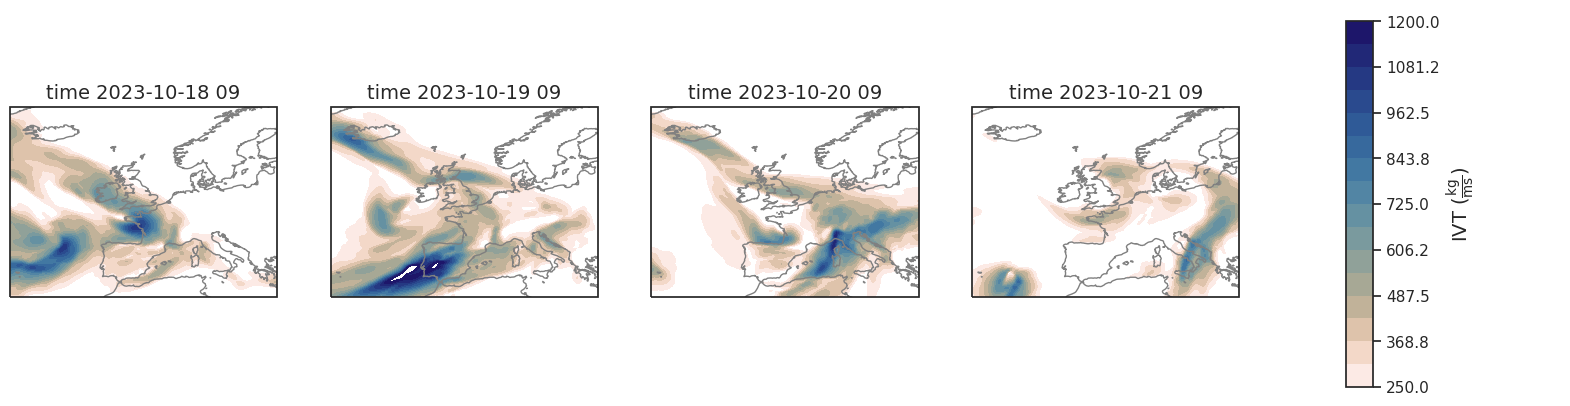

In [8]:
# figure and map setup
fs=14
projection = ccrs.PlateCarree()
longitude =exp['curr'].longitude.values
latitude = exp['curr'].latitude.values
fig = plt.figure(1, figsize=(20, 5))

# Map -----------------
for t, time in enumerate(['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']):
    ax = plt.subplot(1,5,t+1, projection = projection)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

    # data for plotting
    tp_vals = ivt_era.sel(time=time).squeeze().values*100
    p_vals = era5.z.sel(time=time, level=850).squeeze().values

    # tp as shading
    clevs_tp = np.linspace(tp_min, tp_max, 17)
    cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                    transform=projection)
    plt.title('time '+time[:13], fontsize=fs)

    # geopotential as contours
    clevs_p = np.linspace(p_min, p_max, 17)
    cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                    transform=projection)
    plt.clabel(cs, fmt='%d')

# Other figure settings -----------------
ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label=r'IVT ($\frac{\mathrm{kg}}{\mathrm{m}\mathrm{s}}$)', extend = 'max', shrink=0.8)
cbar.set_label(label=r'IVT ($\frac{\mathrm{kg}}{\mathrm{m}\mathrm{s}}$)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

# Test whether Olivia's function yields the same result

In [4]:
# Olivia's function
def get_IVT(ds):
    
    ds =ds.copy()
    
    out = xr.Dataset(coords=ds.coords).drop('level')
    
    out['q_u'] = (ds.q.sel(level=slice(250,1000)) * ds.u.sel(level=slice(250,1000))).integrate('level') / 9.80665
    out['q_v'] = (ds.q.sel(level=slice(250,1000)) * ds.v.sel(level=slice(250,1000))).integrate('level') / 9.80665
    
    return out

In [5]:
ENS_IVT = get_IVT(curr).load()
river=(((ENS_IVT.q_u**2+ENS_IVT.q_v**2)**(1/2)))

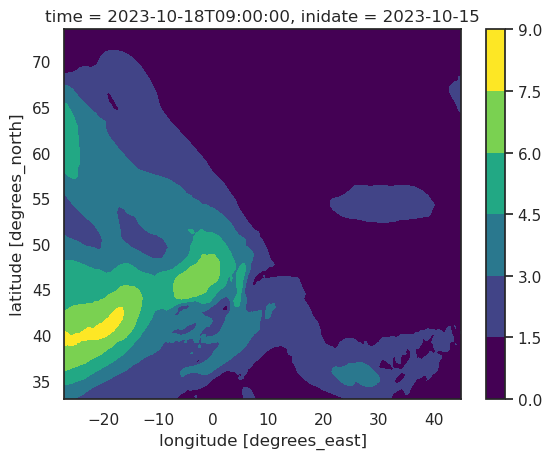

In [13]:
river.sel(time='2023-10-18 09', inidate='2023-10-15').mean('number').plot.contourf(vmax=10, vmin=1)

# Comparing experiments and inidates

NameError: name 'p_vals' is not defined

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


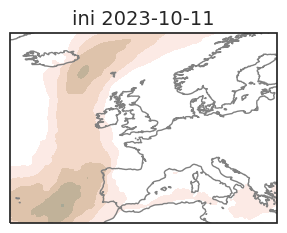

In [6]:
# figure and map setup
fs=14
projection = ccrs.PlateCarree()
longitude =exp['curr'].longitude.values
latitude = exp['curr'].latitude.values
fig = plt.figure(1, figsize=(20, 11))
timestep = '2023-10-19 09'

# Map -----------------
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
for ini, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        ax = plt.subplot(3,5,ini+1+e*5, projection = projection)
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

        # data for plotting
        tp_vals = ivt[experiment].sel(inidate=inidate, time=timestep).squeeze().values*100
        p_vals = exp[experiment].z.sel(inidate=inidate, time=time, level=850).mean('number').squeeze().values

        # tp as shading
        clevs_tp = np.linspace(tp_min, tp_max, 17)
        cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                        transform=projection)
        plt.title('ini '+inidate, fontsize=fs)

        # isobars as contours
        clevs_p = np.linspace(p_min, p_max, 17)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection)
        plt.clabel(cs, fmt='%d')

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label=r'IVT ($\frac{\mathrm{kg}}{\mathrm{m}\mathrm{s}}$)', extend = 'max', shrink=0.8)
cbar.set_label(label=r'IVT ($\frac{\mathrm{kg}}{\mathrm{m}\mathrm{s}}$)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

plt.savefig('figures/05_ivt_all-exp_{}_{}.png'.format(region, timestep))
plt.savefig('figures/05_ivt_all-exp_{}_{}.pdf'.format(region, timestep))

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


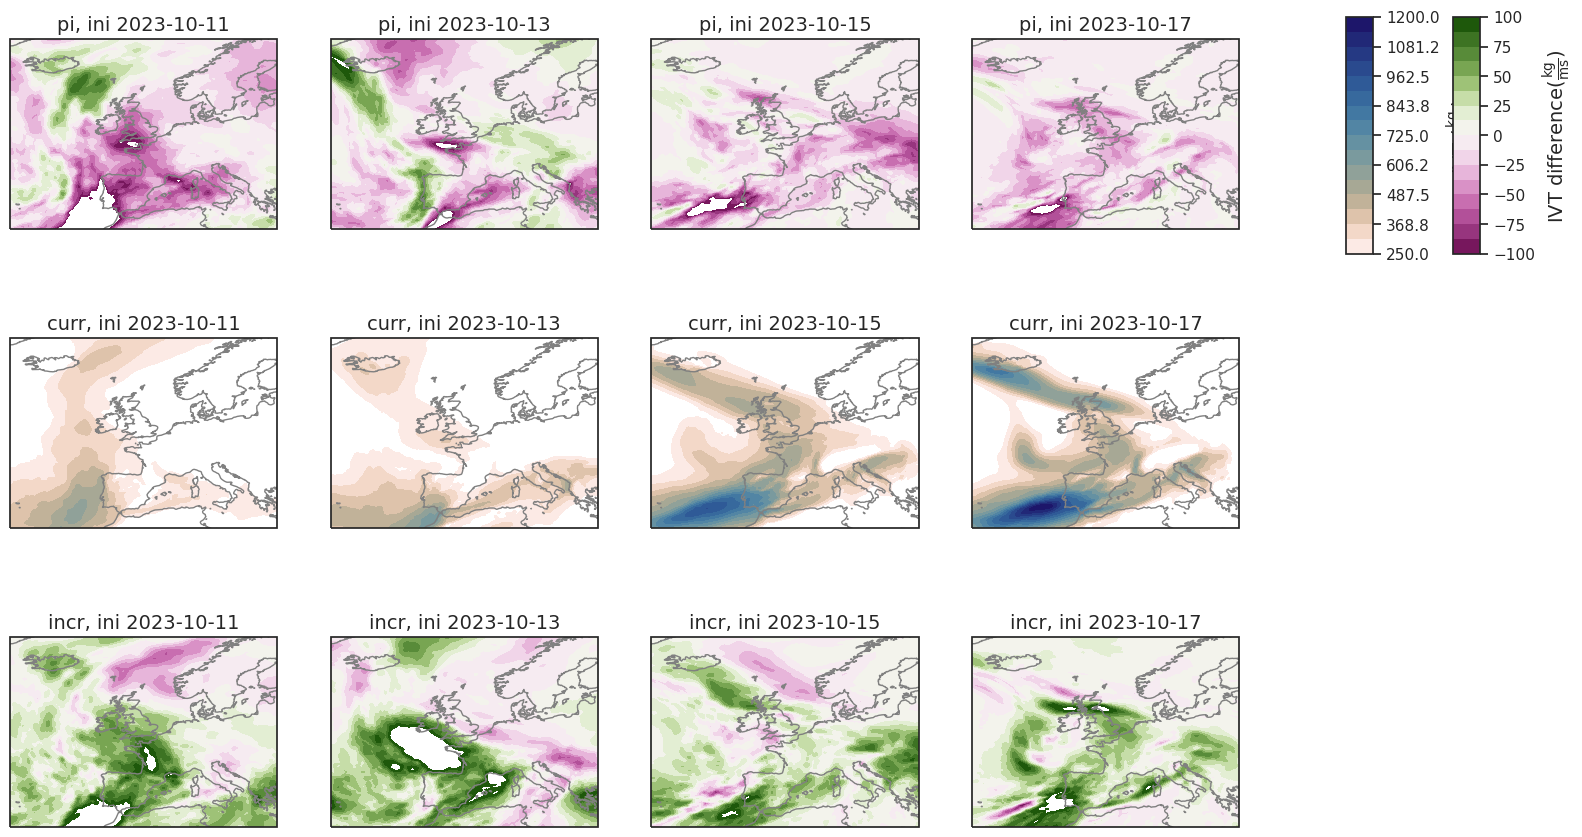

In [13]:
# figure and map setup
fs=14
projection = ccrs.PlateCarree()
longitude =exp['curr'].longitude.values
latitude = exp['curr'].latitude.values
fig = plt.figure(1, figsize=(20, 11))
timestep = '2023-10-19 09'

# Map -----------------
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
for ini, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        ax = plt.subplot(3,5,ini+1+e*5, projection = projection)
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

        # data for plotting
        if experiment == 'curr':
            tp_vals = ivt[experiment].sel(inidate=inidate, time=timestep).squeeze().values*100
        else:
            tp_vals = (ivt[experiment]-ivt['curr']).sel(inidate=inidate, time=timestep).squeeze().values*100
        # p_vals = exp[experiment].z.sel(inidate=inidate, time=time, level=850).mean('number').squeeze().values

        # tp as shading
        if experiment == 'curr':
            clevs_tp = np.linspace(tp_min, tp_max, 17)
            cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                            transform=projection)
        else:
            clevs_tp = np.linspace(-100, 100, 17)
            cf_diff = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.bam,
                            transform=projection)
        
        plt.title(experiment+', ini '+inidate, fontsize=fs)

        # isobars as contours
        # clevs_p = np.linspace(p_min, p_max, 17)
        # cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
        #                 transform=projection)
        # plt.clabel(cs, fmt='%d')

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label=r'IVT ($\frac{\mathrm{kg}}{\mathrm{m}\mathrm{s}}$)', extend = 'max', shrink=0.8)
cbar.set_label(label=r'IVT ($\frac{\mathrm{kg}}{\mathrm{m}\mathrm{s}}$)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.7, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label=r'IVT difference ($\frac{\mathrm{kg}}{\mathrm{m}\mathrm{s}}$)', extend = 'max', shrink=0.8)
cbar_diff.set_label(label=r'IVT difference($\frac{\mathrm{kg}}{\mathrm{m}\mathrm{s}}$)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)

# Lagranto to trace moisture sources

In [37]:
from datetime import datetime, timedelta
startdate = datetime(2023, 10, 15, 0)
enddate = startdate + timedelta(days=7)
total_hours = int((enddate - startdate).total_seconds() / 3600) + 1
timestamps = [(startdate + timedelta(hours=i)).strftime("%Y-%m-%d %H") for i in range(0, total_hours, 3)]

dates = [(datetime.strptime(timestamps[i], "%Y-%m-%d %H"), datetime.strptime(timestamps[i], "%Y-%m-%d %H")+timedelta(hours=48)) for i in range(len(timestamps))]

In [39]:
from lagranto import LagrantoRun
lrun = LagrantoRun(dates, workingdir=base_dir.format('curr'),
                   outputdir='output', version='ecmwf')

In [40]:
# create starting file to track air parcels every 20km
specifier = "'box.eqd(5,20,40,50,20)@profile(850,500,10)@hPa'"
out_create_startf = lrun.create_startf(startdate, specifier, tolist=True)

LagrantoException:  . /etc/profile.d/modules.sh
        module purge
        module load dyn_tools
        export NETCDF_FORMAT=CF
        
    cd '/tmp/user/27529/tmpm1ggcfdd'
     startf.ecmwf 20231015_00 startf.4 'box.eqd(5,20,40,50,20)@profile(850,500,10)@hPa'
    ERROR: Unable to locate a modulefile for 'dyn_tools'
bash: line 7: startf.ecmwf: command not found


In [21]:
# test set up with a single date
out_caltra = lrun.caltra(*dates[1])

TypeError: caltra() missing 1 required positional argument: 'enddate'

In [ ]:
out_trace = lrun.trace(dates[1][0], field='Q 1.')

# Moisture transport into UK

Analyse how much moisture is being transported into the UK box defined earlier and whether this changes at with climate change

In [5]:
# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

In [6]:
def moisture_transport_across_latline(q, v, lat_threshold, toplevel=250, starttime='2023-10-17 00', endtime='2023-10-22 00'):
    g = 9.81 # gravitational constant
    ivt_v = (q * v).sel(level=slice(toplevel, 1000), time=slice(starttime, endtime)).integrate('level') / g
    mass_transport = ivt_v.sel(latitude=lat_threshold, method='nearest').integrate('time').integrate('longitude')
    return mass_transport.to_dataset(name='moisture_transport')

In [7]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1 = np.radians(lat1)
        lat2 = np.radians(lat2)
        lon1 = np.radians(lon1)
        lon2 = np.radians(lon2)

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

## Testing

Check that calculating the moisture transport function yields the same results when all inidates and ensemble members are calculated in one go

In [8]:
q = exp['curr'].sel(time=slice('2023-10-17 00', '2023-10-22 00'), number=1, inidate='2023-10-15').q
v = exp['curr'].sel(time=slice('2023-10-17 00', '2023-10-22 00'), number=1, inidate='2023-10-15').v
lat_threshold = 50

g = 9.81 # gravitational constant
ivt_v = (q * v).sel(level=slice(250, 1000)).integrate('level') / g
mass_transport = ivt_v.sel(latitude=lat_threshold, method='nearest').integrate('time')

In [9]:
mass_transport.integrate('longitude').values

array(2.94480598e+16)

In [10]:
moisture_transport_across_latline(q,v,50).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:             ()
Coordinates:
    inidate             datetime64[ns] 2023-10-15
    latitude            float32 50.0
    number              int32 1
Data variables:
    moisture_transport  float64 dask.array<chunksize=(), meta=np.ndarray>>

In [11]:
moisture_transport_across_latline(exp['curr'].q, exp['curr'].v, 50).sel(inidate='2023-10-15', number=1).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:             ()
Coordinates:
    inidate             datetime64[ns] 2023-10-15
    latitude            float32 50.0
    number              int32 1
Data variables:
    moisture_transport  float64 dask.array<chunksize=(), meta=np.ndarray>>

In [12]:
# test integrate function
da = xr.DataArray(
    np.arange(12).reshape(4, 3),
    dims=["x", "y"],
    coords={"x": [0, 0.1, 1.1, 1.2]})
da

<xarray.DataArray (x: 4, y: 3)>
array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])
Coordinates:
  * x        (x) float64 0.0 0.1 1.1 1.2
Dimensions without coordinates: y

In [13]:
da.integrate('x')

<xarray.DataArray (y: 3)>
array([5.4, 6.6, 7.8])
Dimensions without coordinates: y

## Plotting

In [14]:
# def moisture_transport_into_box(ivt, [lat_min, lat_max, lon_min, lon_max]):
#     diff_ivt = ivt.diff(['latitude', 'longitude'])
#     return np.nan

In [15]:
# moisture transport for all experiments and inidates
moisture_transport = {key : moisture_transport_across_latline(value.q, value.v, 50) for key, value in exp.items()}
moisture_transport_df = pd.concat([moisture_transport['curr'].to_dataframe().assign(exp='curr'),
                                   moisture_transport['pi'].to_dataframe().assign(exp='pi'),
                                   moisture_transport['incr'].to_dataframe().assign(exp='fut')])

In [22]:
# moisture_transport_df.to_csv('/home/e/ermis/Storm_Babet/data/moisture_transport.csv')
# moisture_transport_df = pd.read_csv('/home/e/ermis/Storm_Babet/data/moisture_transport.csv')

In [16]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from moarpalettes import get_palette

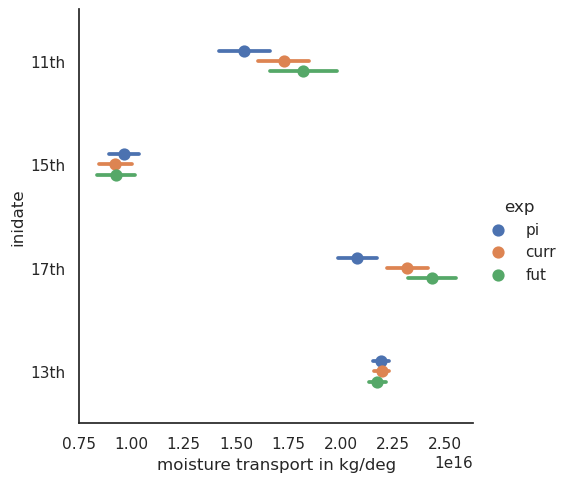

In [17]:
fs = 18  # fontsize
g = sns.catplot(data=moisture_transport_df.reset_index(),
                        x='moisture_transport',
                        y='inidate',
                        hue='exp',
                        hue_order=['pi','curr','fut'],
                        # palette=get_palette.Petroff6().to_sn_palette(),
                        kind='point',
                        errorbar=('ci',90),
                        dodge=0.2,
                        join=False,
                        n_boot=10000,
                        legend = True, 
                        height=5, 
                        aspect=1.5)
inidates = ['11th', '15th', '17th', '13th']
g.set(xlabel='moisture transport in kg/deg', yticklabels=inidates)

plt.savefig('figures/05_moisture_transport_across50N.png')
plt.savefig('figures/05_moisture_transport_across50N.pdf')